In [2]:
import numpy as np
import xarray as xr
from itertools import product
import xsimlab as xs
from xsimlab import variable as var, global_ref as glob
import pandas as pd
import zarr
import matplotlib.pyplot as plt
import networkx as nx

# 20210731_sandbox

Entities:
- Variables
    - State matrix (SM)
    - State transition matrix (TM)
- Processes
    - Multiple processes edit TM
        - FOI process edits TM only on index of S and E compartments
        - I -> R transition is goverened by some process that
            - Ingests gamma
            - Edits TM
    - TM-editing processes interface
        - Inputs: SM(t), contacts per time, contact probability, other epi params, etc.
        - Output: TM(t)
    - Provide t0 SM
    - Step
        - Apply operation SM(t) * TM(t)
        - Ouputs SM(t+1)

- Potential to populate different subsets of SM async from multiple processes?
    - Keep it at 1 for now

First pass:
- S -> E progression
    - FOI is f(I, N) where N is sum over all compartments

## What do I mean when I say "edit TM"?

- Ideally, a process that "edits" TM is one that
    - Ingests a TM
    - Indexes TM, inserting along only the compartments it edits
    - Outputs a TM with fewer NaNs
    - Therefore represents TM as an `inout` variable in xsimlab
- The problem is that multiple `inout` processes are not allowed in xsimlab due to ambiguity in the task graph

### Solution

- What we could do is provide multiple processes that output *distinct* subsets of the TM
    - Each subset would be defined like `xs.variable(groups=['tm_subsets'])`
- Then an aggregator process `AggTM` ingests all the subsets of the TM using `xsimlab.group_dict`

## How to prioritize application of edge weights?

*Problem*: we have many processes telling `AggregateTM` the weights of different edges in the compt graph. But we don't know in which order to apply them.

- For alpha, we can assume that there are no cycles in the compt graph. So the higher a node is in the tree, the higher the priority of its edges.
- For now, we can assume that we will somehow calculate the order in which edges should be applied

Asked KP the following Q this weekend:
> I have a very naive question about discrete time SIR models: given the standard graph that represents compartments: S -> I -> R and there's also an R -> S edge to make a cycle
> 
> ```
> weight of S node           : 50
> FOI (weight of S -> I edge): -60
> weight of R -> S edge      : 20
> ```
> 
> in discrete time, what is the weight of the S node at t + 1?
> 1. `50 + -60 + 20 = 10`
> 2. `max([50 + -60, 0]) + 20 = 20`
> 3. `max([50 + 20, 0]) + -60 = 10`

In other words, I'm unsure if there are "higher priority" edges or nodes that dictate the order of operations. This is how the original model from Suzanna and Remy implemented, but many examples of continuous time SEIR models I have seen (such as KP's SEIR_Example repo) do not have an order of operations.

KP:
> so I would say that the S node has a state, which is its population at time t, and the edge between S and I has a weight, which is the delta S (population moving S to I) at time t
> so both node state and edge weight will vary with time
> I'm thinking about it like this:
> ```
> time = t
> state of S node           : 50 people
> weight of S -> I          : -60 people
> weight of R -> S          : 20 people
> update t+1
> state of S node           : 50 - max((50-60), 0) + 20 = 20
> weight of S -> I          : recalculate FOI
> weight of R -> S          : recalculate weight
> ```
> so tl;dr, #2 in your options above

Ethan:
> Thanks! So #2 and #3 imply that there is an order of operations for adding/subtracting edge weights to the t state (to get t + 1). #2 is the result if the S -> I edge is applied before R -> S (as Remy and Suzanna's model does), and #3 is the result if R -> S is applied before S -> I.
> For graphs that are trees/paths, the order of operations is pretty unambiguous: first apply edges at the beginning of the path (S -> I in the case of SIR model without reinfection). But with reinfection (R -> S edge exists), there is ambiguity due to the presence of a cycle.

KP:
> right. I am trying to think if the order of operations matters if you were doing a diffeq model instead, and I'm not sure. but I think I would stick with the order of ops that matches the flow through the compartments
> not good enough at calc or linear algebra to think through the consequences of different order of ops!

Ethan:
> yep, thats what I was confused about. In the continuous time models, they dont even consider this
>
> For instances of basic SIR models (even with reinfection), it's not too complicated. Just ask the user what the order of operations is (assuming S -> I comes first by default). But this ordinality has some more sinister implications when the order of ops is not clear, such the below vaccination model. What rules govern how we depopulate the S compartment here? Do we: 
> 1. Depopulate S using the S -> V 
> 2. S -> I edge first? 
> 3. Do we instead scale down weights of both edges by some k?
>
> so why am I beleaguering you with all this low level math stuff? Turns out that this order of ops is critical to how generalizable our "universal compartmental model runner" will be, so this heavily influences the estimated value of Episimlab as a deliverable.
>
> I would reach out to Meyers folks about this, but I get the sense that the only people who would know are busy wrangling different versions of R code

KP:
> gotcha, yeah good to think through this very carefully. I'll look at the order of ops in Michael's R code
> I think you take S->I, then S->V, but I'll need to take a closer look

Kelly Pierce  12:53 PM
> Michael's code follows this order of operations: new_S = S - new_E - new_V where new_V is drawn from a hypergeometric distribution (still trying to wrap my head around that). I don't see any special handling for what happens when new_E > S , but it could be elsewhere in the code (or irrelevant for their models which don't project out to herd immunity
> [this is the code](https://tacc-team.slack.com/files/UEK70HQLF/F029Y1HBG4T/mobility_agegroups_ar1_mu_pres_risk-simple_vacc_delta.r.cpp?origin_team=T03EBR1EB&origin_channel=DU9V71VU2) Michael shared with me; vaccination handling starts on line 419

Ethan:
> Thanks, this is very helpful!
> Yeah I dont see anything here about checking that new_S < 0 , maybe Im overthinking this...

Giving some more thought to this, there is not a general solution of the following that will apply to all use cases:
1. Depopulate S using the S -> V 
2. S -> I edge first? 
3. Do we instead scale down weights of both edges by some k?

- #1 and #2 both should be supported depending on user preferences.
- #3 should also be supported
	- One example is the [Pa and Py compartments](https://github.com/eho-tacc/episimlab/blob/b409c88b262cd91783cd35ecc0d6fb14623ac891/episimlab/seir/brute_force.py#L197), which, if I remember correctly, are applied simultanetously scale down by some *k* factor.
	- Not directly a *k* factor, but `rate_E2P` is calculated as the sum of E -> Pa and E -> Py edges, and the ratio of the edge weights is determined by the tau epi param.
- In summary, the compartment graph should have this order of operations encoded when it is passed as a variable to `AggregateTM` process or similar.
- This order of operations will be given from upstream processes, either by:
	- Ingesting it from the user somehow
	- Or intuiting reasonable defaults for simple/common use cases
		- Paths
		- Maybe trees
- A few different libraries for representing this variable, but networkx is probably the best option
	- Familiar
	- Well supported
	- Good digraph support

## What to spec now

- [x] Can set a [`nx.DiGraph`](https://networkx.org/documentation/stable/reference/classes/digraph.html) as an `xs.variable`

----

From Kelly's [SEIR_Example](https://github.com/UT-Covid/SEIR_Example/blob/03d4e34826febd8da61270efb175ddf79e828b40/src/seir.py) repo:
```python
def seir(self, x, t):

    S = x[0]
    E = x[1]
    I = x[2]
    R = x[3]

    y = np.zeros(4)

    y[0] = self.mu - ((self.beta * I) + self.mu) * S + (self.omega * R)
    y[1] = (self.beta * S * I) - (self.mu + self.sigma) * E
    y[2] = (self.sigma * E) - (self.mu + self.gamma) * I
    y[3] = (self.gamma * I) - (self.mu * R) - (self.omega * R)

    return y

def integrate(self):

    time = np.arange(0, self.duration, 0.01)
    results = scipy.integrate.odeint(self.seir, self.R, time)

    return results
```

# Utils from Episimlab

In [3]:
def try_coerce_to_da(self, name, value):
    """Given a variable with `name`, and `value` set from a config file,
    retrieve the variable metadata and use it to coerce the `value` into
    an `xarray.DataArray` with the correct dimensions and coordinates.
    Returns `value` if variable is scalar (zero length dims attribute),
    DataArray otherwise.
    """
    # get dims
    dims = get_var_dims(self.KEYS_MAPPING[name], name)
    if not dims:
        return value
    # get coords
    coords = {dim: getattr(self, dim) for dim in dims if dim != 'value'}
    return xr.DataArray(data=value, dims=dims, coords=coords)

In [4]:
def get_var_dims(process, name) -> tuple:
    """Given process-wrapped class `process`, retrieve the `dims` metadata
    attribute for variable with `name`.
    """
    if not '__xsimlab_cls__' in dir(process):
        raise TypeError(
            f"Expected type 'xsimlab.Process' for arg `process`, received " +
            f"'{type(process)}'"
        )
    var = xs.utils.variables_dict(process).get(name, None)
    if var is None:
        raise AttributeError(f"process '{process}' has no attribute '{name}'")
    return tuple(var.metadata['dims'][0])


In [5]:
def group_dict_by_var(d: dict) -> dict:
    return {k: d[(proc, k)] for (proc, k) in d}

## Define Processes

In [98]:
@xs.process
class RecoveryRate:
    """Provide a `rate_I2R`"""
    rate_I2R = var(global_name='rate_I2R', groups=['tm'], intent='out')
    gamma = var(global_name='gamma', intent='in')
    state = glob('state', intent='in')

    def run_step(self):
        self.rate_I2R = self.gamma * self.I
    
    @property
    def I(self):
        return self.state.loc[dict(compt='I')]

In [99]:
@xs.process
class InitComptGraph:
    """Generate a toy compartment graph"""
    compt_graph = glob('compt_graph', intent='out')

    def get_compt_graph(self) -> nx.DiGraph:
        g = nx.DiGraph()
        g.add_nodes_from([
            ('S', {"color": "red"}),
            ('I', {"color": "blue"}),
            ('R', {"color": "green"}),
        ])
        g.add_edges_from([
            ('S', 'I', {"priority": 0, "color": "red"}),
            ('I', 'R', {"priority": 1, "color": "blue"}),
        ])
        return g
    
    def vis(self):
        return nx.draw(self.compt_graph)
    
    def initialize(self):
        self.compt_graph = self.get_compt_graph()

In [116]:
@xs.process
class SEIR:
    """Sums subsets of TM (in group `tm`) from many processes to output TM."""
    STATE_DIMS = ('compt', 'age',)
    _tm_subset = xs.group_dict('tm')
    state = var(dims=STATE_DIMS, intent='inout', global_name='state')
    tm = var(dims=STATE_DIMS, intent='out', global_name='tm')
    compt_graph = var('compt_graph', intent='in', global_name='compt_graph')
    
    def run_step(self):
        """In particular, we need to ensure that `tm_subset` and `tm` refresh
        at every timestep.
        """
        self.tm = self.init_tm()
        self.tm_subset = self.get_tm_subset()
        self.apply_edges()

    def finalize_step(self):
        self.state += self.tm
        
    def init_tm(self):
        """Initialize transition matrix (TM) as a matrix of zeros."""
        return xr.zeros_like(self.state)
        
    def apply_edges(self):
        """Iterate over edges in `compt_graph` in ascending order of `priority`.
        Apply each edge to the TM.
        """
        # TODO: represent as tuples by prioirity
        for (u, v) in self.compt_graph.edges:
            self.edge_to_tm(u, v)
    
    def edge_to_tm(self, u, v) -> None:
        """Applies to the transition matrix (TM) the weight of a directed edge 
        from compartment `u` to compartment `v`. Find the element-wise
        minimum of origin node state and weight of outgoing edge to ensure
        that origin node state is always non-negative after edge weight has
        been applied.
        """
        weight = xr.ufuncs.minimum(
            # origin node weight
            self.state.loc[dict(compt=u)],
            # unadjusted edge weight
            self.edge_weight(u, v)
        )
        # print(f"adjusted weight of edge from {u} to {v} is {weight}")
        self.tm.loc[dict(compt=u)] -= weight
        self.tm.loc[dict(compt=v)] += weight
        
    def edge_weight(self, u, v):
        """Try to find an edge weight for (u, v) from `tm_subset`."""
        key = self.edge_weight_name(u, v)
        if key not in self.tm_subset:
            print(f"WARNING: could not find a weight for transition from {u} to {v} compartment ({key})")
            weight = 0.
        else:
            weight = self.tm_subset[key]
        return weight
    
    def edge_weight_name(self, u, v) -> str:
        """Key to look for when finding edge weights between nodes `u` and `v`."""
        return f"rate_{u}2{v}"
    
    def get_tm_subset(self):
        """`_tm_subset` indexes on (`process_name`, `variable_name`), so we must convert
        keys to `variable_name`.
        """
        return group_dict_by_var(self._tm_subset)

In [117]:
@xs.process
class InitCoords:
    """Initialize state coordinates"""
    compt = var(global_name='compt_coords', groups=['state_coords'], intent='out')
    age = var(global_name='age_coords', groups=['state_coords'], intent='out')
    
    def initialize(self):
        self.compt = ['S', 'I', 'R'] 
        self.age = ['0-4', '5-17', '18-49', '50-64', '65+']

In [118]:
@xs.process
class InitState:
    """Initialize state matrix"""
    _state_coords = xs.group_dict('state_coords')
    state = glob('state', intent='out')
    
    def initialize(self):
        self.state = xr.DataArray(
            data=0.,
            dims=self.state_dims,
            coords=self.state_coords
        )
        self.state.loc[dict(compt='S')] = np.array([1000, 900, 800, 700, 600])
        self.state.loc[dict(compt='I')] = np.array([100, 90, 80, 70, 60])
    
    @property
    def state_dims(self):
        return get_var_dims(SEIR, 'state')
    
    @property
    def state_coords(self):
        return group_dict_by_var(self._state_coords)

In [119]:
@xs.process
class InitPhi:
    """Set value of phi (contacts per unit time)."""
    PHI_DIMS = ('age0', 'age1')
    RANDOM_PHI_DATA = np.array([
        [0.89, 0.48, 0.31, 0.75, 0.07],
        [0.64, 0.69, 0.13, 0.00, 0.05],
        [0.46, 0.58, 0.19, 0.16, 0.11],
        [0.53, 0.36, 0.26, 0.35, 0.13],
        [0.68, 0.70, 0.36, 0.23, 0.28]
    ]) 
    phi = glob('phi', intent='out')
    age_coords = glob('age_coords', intent='in')
    
    def initialize(self):
        data = self.RANDOM_PHI_DATA
        self.phi = xr.DataArray(data=data, dims=self.phi_dims, coords=self.phi_coords)
    
    @property
    def phi_dims(self):
        return ('age0', 'age1')
    
    @property
    def phi_coords(self):
        return dict(age0=self.age_coords, age1=self.age_coords)

In [120]:
@xs.process
class FOI:
    """Calculate force of infection (FOI) with naive
    for looping.
    """
    PHI_DIMS = ('age0', 'age1')
    FOI_DIMS = ('age',)
    state = glob('state', intent='in')
    beta = var(global_name='beta', intent='in')
    phi = var(dims=PHI_DIMS, global_name='phi', intent='in')
    rate_S2I = var(intent='out', groups=['tm'])
    age_coords = glob('age_coords', intent='in')
    
    def initialize(self):
        self.rate_S2I = 0.
    
    def run_step(self):
        # self.rate_S2I = self.brute_force_foi
        # assert np.testing.assert_allclose(self.brute_force_foi.values, self.foi.values)
        # print(self.brute_force_foi, self.foi)
        # assert 0
        # breakpoint()
        self.rate_S2I = self.foi
    
    def init_foi(self) -> xr.DataArray:
        return xr.DataArray(data=0., dims=self.FOI_DIMS, coords=dict(age=self.age_coords))
    
    @property
    def foi(self) -> xr.DataArray:
        S = self.S.rename({'age': 'age0'})
        I = self.I.rename({'age': 'age1'})
        N_flat = self.state.sum('compt')
        N = xr.concat([N_flat] * len(self.age_coords), dim='age1').rename({'age': 'age0'})
        # print(N)
        self.N_arr_np = N
        # breakpoint()
        foi = (self.beta * self.phi * S * I / N).sum('age1').rename({'age0': 'age'})
        # print(f"np {N}")
        # foi is same except for denominator
        return foi
        
    @property
    def brute_force_foi(self) -> xr.DataArray:
        foi = self.init_foi()
        self.N_arr = xr.DataArray(float('nan'), dims=('age0', 'age1'), coords=dict(age0=self.age_coords, age1=self.age_coords))
        for a0, a1 in product(*[self.age_coords] * 2):
            print(a0, a1)
            phi = self.phi.loc[a0, a1].values
            S = self.S.loc[dict(age=a0)].values
            I = self.I.loc[dict(age=a1)].values
            N = self.state.loc[dict(age=a0)].sum('compt').values
            # foi is same except for denominator
            # print(f"bf {N}")
            self.N_arr.loc[dict(age0=a0, age1=a1)] = N
            foi.loc[dict(age=a0)] += phi * self.beta * S * I / N
        return foi
    
    @property
    def foi_scalar(self):
        """Only works if phi is a scalar."""
        return self.phi * self.beta * self.S * self.I / self.N
    
    @property
    def S(self):
        return self.state.loc[dict(compt='S')]
        
    @property
    def I(self):
        return self.state.loc[dict(compt='I')]
    
    @property
    def N(self):
        return self.state.sum()

## Run Model

In [121]:
model = xs.Model({
    'init_phi': InitPhi,
    'init_coords': InitCoords,
    'init_state': InitState,
    'seir': SEIR,
    'foi': FOI,
    'init_compt_graph': InitComptGraph,
    'recovery_rate': RecoveryRate
})
# model.visualize(show_inputs=True, show_variables=True)

In [122]:
in_ds = xs.create_setup(
    model=model,
    clocks={
        'step': pd.date_range(start='3/1/2020', end='3/15/2020', freq='24H')
    },
    input_vars={
        'foi__beta': 0.7,
        'recovery_rate__gamma': 0.5,
    },
    output_vars={
        'seir__state': 'step'
    }
)
out_ds = in_ds.xsimlab.run(model=model, decoding=dict(mask_and_scale=False))

In [123]:
out_ds

<xarray.Dataset>
Dimensions:               (step: 15, compt: 3, age: 5)
Coordinates:
  * step                  (step) datetime64[ns] 2020-03-01 ... 2020-03-15
Dimensions without coordinates: compt, age
Data variables:
    foi__beta             float64 0.7
    recovery_rate__gamma  float64 0.5
    seir__state           (step, compt, age) float64 1e+03 900.0 ... 741.2 658.7

## Plot Results

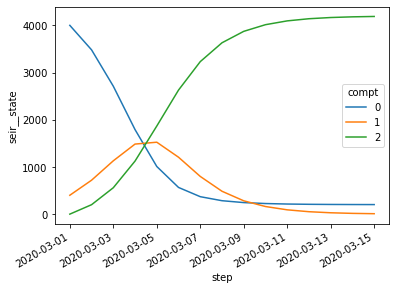

In [124]:
out_ds['seir__state'].sum('age').plot.line(x='step')